# Librerias

In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('../full_portfolio_analysis.ipynb'), '..'))
os.chdir(root_dir)

sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:
from backtesting import Strategy
import pandas as pd
import talib as ta
import pandas_ta as pandas_ta
from datetime import datetime
import itertools
import MetaTrader5 as mt5
import pytz
from backtest.utils import plot_full_equity_curve, walk_forward
import numpy as np
import random
random.seed(42)

In [3]:
initial_cash = 1_000

# Obtener datos

In [4]:
# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 
# get all symbols
symbols = mt5.symbols_get()


groups = []
for symbol in symbols:
    group = symbol.path.split('\\')[0]
    if not group in groups:
        groups.append(group)
groups


['Forex_Indicator',
 'CryptoCross_grp',
 'Crypto_group',
 'Energies_group',
 'Forex_group',
 'Indices_group',
 'Stocks_group']

In [5]:
tickers = ['TMEm', 'WMTm', 'TSMm']
print(tickers)

['TMEm', 'WMTm', 'TSMm']


In [6]:
intervals = [
    mt5.TIMEFRAME_H4,
]

parameter_combinations = list(itertools.product(
    tickers, intervals
))

symbols = {}

print("MetaTrader5 package author: ", mt5.__author__)
print("MetaTrader5 package version: ", mt5.__version__)

# Establecer conexión con el terminal de MetaTrader 5
if not mt5.initialize():
    raise Exception("initialize() failed, error code =", mt5.last_error())

# Establecer la zona horaria a UTC
timezone = pytz.timezone("Etc/UTC")

# Crear objetos 'datetime' en zona horaria UTC
utc_from = datetime(2010, 10, 1, tzinfo=timezone)
utc_to = datetime(2024, 9, 1, tzinfo=timezone)

for ticker, interval in parameter_combinations:
    print(ticker)
    # Obtener las tasas históricas
    rates = mt5.copy_rates_range(ticker, interval, utc_from, utc_to)
    
    # Crear DataFrame con las tasas
    df = pd.DataFrame(rates)
    
    # Convertir el tiempo de segundos a formato datetime
    df['time'] = pd.to_datetime(df['time'], unit='s')


    # Renombrar columnas para el ticker principal
    df = df.rename(columns={
        'time': 'Date',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'tick_volume': 'Volume'
    }).set_index('Date')


    df.index = df.index.tz_localize('UTC').tz_convert('UTC')
    
    utc_to_ts = pd.Timestamp(utc_to).tz_convert('UTC')

    days = (utc_to_ts - df.index[-1]).days
    if days >= 4:
        tickers.remove(ticker)
        print(f'se descarto {ticker}')
        continue

    if ticker not in symbols.keys():
        symbols[ticker] = {}
        symbols[ticker][interval] = {}

    symbols[ticker][interval] = df


# Cerrar la conexión con MetaTrader 5
mt5.shutdown()



MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288
TMEm
WMTm
TSMm


True

In [7]:
max_start_date = None
intervals_start_dates = {}

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date

intervals_start_dates

{16388: Timestamp('2021-10-27 16:00:00+0000', tz='UTC')}

# WFO

In [8]:
from backbone.utils.general_purpose import calculate_units_size, diff_pips

class DayPerWeek(Strategy):
    risk = 10
    day_to_buy = 3
    percentage_price_sl = 5
    sma_period = 200
    rsi_period = 2
    rsi_upper_threshold = 90
    pip_value = 0.1
    
    def init(self):
        self.sma = self.I(
            ta.SMA, self.data.Close, timeperiod=self.sma_period
        )

        self.rsi = self.I(
            ta.RSI, self.data.Close, 2
        )
        
    def next(self):
        today = self.data.index[-1]
        if self.position:
            if self.position.is_long:
                if self.rsi > self.rsi_upper_threshold:
                    self.position.close()

        else:
            # es el dia de compra, el precio esta por encima de la sma
            if today.day_of_week == self.day_to_buy and self.data.Close[-1] > self.sma[-1]:
                sl_price = self.data.Close[-1] - self.data.Close[-1] *  (self.percentage_price_sl / 100)
                
                pip_distance = diff_pips(
                    self.data.Close[-1], 
                    sl_price, 
                    pip_value=self.pip_value
                )
                
                units = calculate_units_size(
                    account_size=self.equity, 
                    risk_percentage=self.risk, 
                    stop_loss_pips=pip_distance, 
                    pip_value=self.pip_value
                )
                
                self.buy(
                    size=units,
                    sl=sl_price,
                )

In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression

def optim_func_2(stats):
    equity_curve = stats._equity_curve['Equity'].values    
    x = np.arange(len(equity_curve)).reshape(-1, 1)
    reg = LinearRegression().fit(x, equity_curve)
    stability_ratio = reg.score(x, equity_curve)
    
    return (stats['Return [%]'] /  (1 + (-1*stats['Max. Drawdown [%]']))) * np.log(1 + stats['# Trades']) * stability_ratio
    

In [10]:
stats_per_symbol = {}

strategy = DayPerWeek

wfo_performance = pd.DataFrame()
for ticker, intervals in symbols.items():
    for interval in intervals:
        print(ticker, interval)
        
        lookback_bars = 1000
        validation_bars = 250
        warmup_bars = 200

        params = {
            'day_to_buy': list(np.arange(0, 5, 1)),
            'percentage_price_sl': list(np.arange(2, 20, 2)),
            'maximize': optim_func_2
        }

        try:
            wfo_stats = walk_forward(
                strategy,
                symbols[ticker][interval], 
                lookback_bars=lookback_bars,
                validation_bars=validation_bars,
                warmup_bars=warmup_bars, 
                params=params,
                commission=7e-4, 
                margin=1/30, 
                cash=initial_cash,
                verbose=False
            )
            
            stats_per_symbol[ticker] = {}
            stats_per_symbol[ticker][interval] = wfo_stats
            
            df_equity = wfo_stats['_equity']
            df_trades = wfo_stats['_trades']
            
            plot_full_equity_curve(df_equity, title=f'{ticker}, {interval}')        
            
            # Calculo el stability ratio
            x = np.arange(df_equity.shape[0]).reshape(-1, 1)
            reg = LinearRegression().fit(x, df_equity.Equity)
            stability_ratio = reg.score(x, df_equity.Equity)
            

            # Extraigo metricas
            df_stats = pd.DataFrame({
                'strategy':[strategy.__name__],
                'ticker':[ticker],
                'interval':[interval],
                'stability_ratio':[stability_ratio],
                'return':[wfo_stats['Return [%]']],
                'final_eq':[wfo_stats['Equity Final [$]']],
                'drawdown':[wfo_stats['Max. Drawdown [%]']],
                'drawdown_duration':[wfo_stats['Max. Drawdown Duration']],
                'win_rate':[wfo_stats['Win Rate [%]']], 
                'sharpe_ratio':[wfo_stats['Sharpe Ratio']],
                'trades':[df_trades.shape[0]],
                'avg_trade_percent':[wfo_stats['Avg. Trade [%]']],
                'exposure':[wfo_stats['Exposure Time [%]']],
                'final_equity':[wfo_stats['Equity Final [$]']],
                'Duration':[wfo_stats['Duration']],

            })

            wfo_performance = pd.concat([wfo_performance, df_stats])
        
        except:
            print(f'No se pudo ejecutar para el ticker {ticker}')

wfo_performance['return/dd'] = wfo_performance['return'] / -wfo_performance['drawdown']
wfo_performance['drawdown'] = -wfo_performance['drawdown']
wfo_performance['custom_metric'] = (wfo_performance['return'] / (1 + wfo_performance.drawdown)) * np.log(1 + wfo_performance.trades)

wfo_performance.drawdown_duration = pd.to_timedelta(wfo_performance.drawdown_duration)
wfo_performance.drawdown_duration = wfo_performance.drawdown_duration.dt.days

wfo_performance.sort_values(by='return/dd', ascending=False)

TMEm 16388


WMTm 16388


TSMm 16388


,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,DayPerWeek,WMTm,16388,0.900966,17.751813,1177.518129,5.815917,63,70.370370,1.910547,27,0.419164,11.256700,1177.518129,1038 days,3.052281,8.678608
0,DayPerWeek,TSMm,16388,0.833337,84.340646,1843.406463,29.460787,128,71.698113,0.836772,53,0.692214,9.676062,1843.406463,1038 days,2.862810,11.044806
0,DayPerWeek,TMEm,16388,0.508285,69.892008,1698.920083,55.358191,65,56.410256,0.442642,39,0.831966,10.065515,1698.920083,1038 days,1.262541,4.574724


In [11]:
filtered_wfo_performance = wfo_performance[
    (wfo_performance.stability_ratio > 0.65)
    & (wfo_performance['return/dd'] > 2)
].sort_values(by='return/dd', ascending=False)

filtered_wfo_performance

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,DayPerWeek,WMTm,16388,0.900966,17.751813,1177.518129,5.815917,63,70.370370,1.910547,27,0.419164,11.256700,1177.518129,1038 days,3.052281,8.678608
0,DayPerWeek,TSMm,16388,0.833337,84.340646,1843.406463,29.460787,128,71.698113,0.836772,53,0.692214,9.676062,1843.406463,1038 days,2.862810,11.044806


# Montecarlo

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from backtest.utils import montecarlo_statistics_simulation

# Crear una lista para almacenar los resultados de cada ticker
data_drawdown = []
data_return = []
montecarlo_simulations = {}

all_drawdowns = pd.DataFrame()
all_returns = pd.DataFrame()

for ticker in filtered_wfo_performance.ticker.tolist():
    print(f"Procesando ticker: {ticker}")
    trades_history = stats_per_symbol[ticker][16388]._trades
    eq_curve = stats_per_symbol[ticker][16388]._equity_curve
    
    # Simulación de Montecarlo para cada ticker (datos agregados)
    mc, synthetic_drawdown_curve, synthetic_return_curve = montecarlo_statistics_simulation(
        equity_curve=eq_curve,
        trade_history=trades_history, 
        n_simulations=100_000, 
        initial_equity=initial_cash, 
        threshold_ruin=0.8, 
        return_raw_curves=True,
        percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
    )
    
    montecarlo_simulations[ticker] = mc
    
    synthetic_drawdown_curve['ticker'] = ticker
    synthetic_return_curve['ticker'] = ticker
    
    all_drawdowns = pd.concat([all_drawdowns, synthetic_drawdown_curve])
    all_returns = pd.concat([all_returns, synthetic_return_curve])

Procesando ticker: WMTm
Procesando ticker: TSMm


In [17]:
dd_df = pd.DataFrame()
returns_df = pd.DataFrame()

for ticker, mc in montecarlo_simulations.items():
    mc = mc.rename(
        columns={
            'Drawdown (%)': f'drawdown_{ticker}',
            'Final Return (%)': f'return_{ticker}',
        }
    )

    if dd_df.empty:
        dd_df = mc[[f'drawdown_{ticker}']]
    
    else:
        dd_df = pd.merge(
            dd_df,
            mc[[f'drawdown_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
    if returns_df.empty:
        returns_df = mc[[f'return_{ticker}']]
    
    else:
        returns_df = pd.merge(
            returns_df,
            mc[[f'return_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
display(dd_df)
display(returns_df)


,drawdown_WMTm,drawdown_TSMm
count,100000.000000,100000.000000
mean,-2.206838,-20.510318
std,1.068741,7.846157
min,-11.847946,-65.416831
10%,-3.606716,-31.196607
25%,-2.742406,-24.846384
50%,-2.006028,-19.112430
75%,-1.456632,-14.773660
90%,-1.065151,-11.770162
max,0.000000,-3.611166


,return_WMTm,return_TSMm
count,100000.000000,100000.000000
mean,16.600480,99.955690
std,6.453785,77.329428
min,-8.219084,-63.095565
10%,8.420700,15.578200
25%,12.154264,45.077764
50%,16.431409,86.632278
75%,20.858839,139.983410
90%,24.975529,201.146841
max,47.844815,822.308679


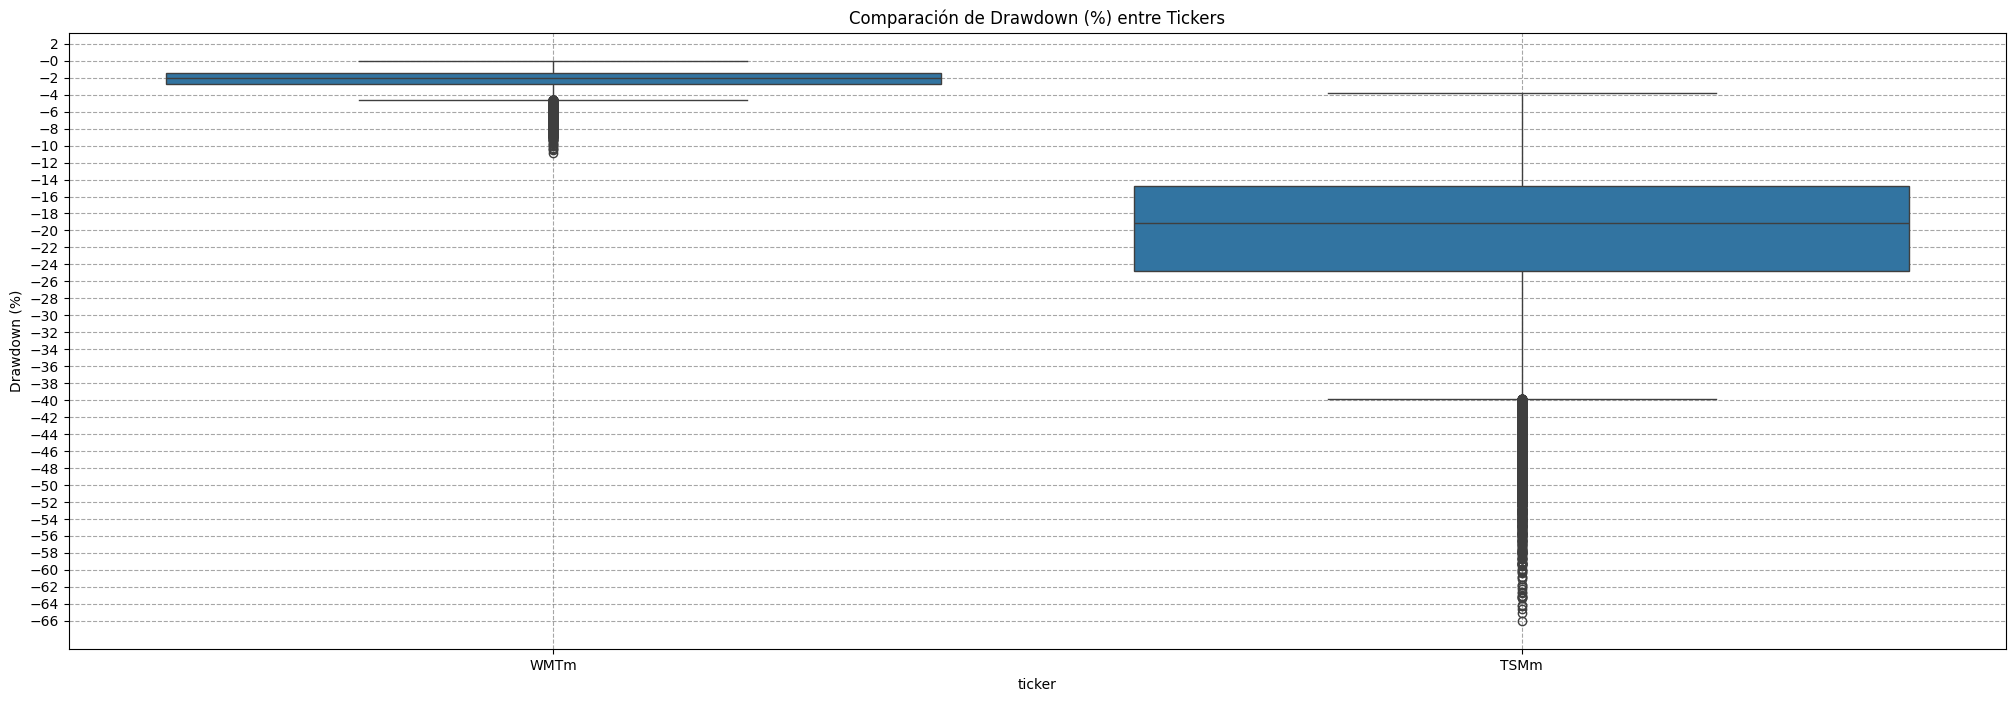

In [14]:
# Configurar el gráfico con matplotlib y seaborn
plt.figure(figsize=(25, 8))
sns.boxplot(data=all_drawdowns, x="ticker", y="Drawdown (%)")
plt.title("Comparación de Drawdown (%) entre Tickers")

y_max = all_drawdowns["Drawdown (%)"].max()  # Valor máximo en el eje Y
y_min = all_drawdowns["Drawdown (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 2  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()

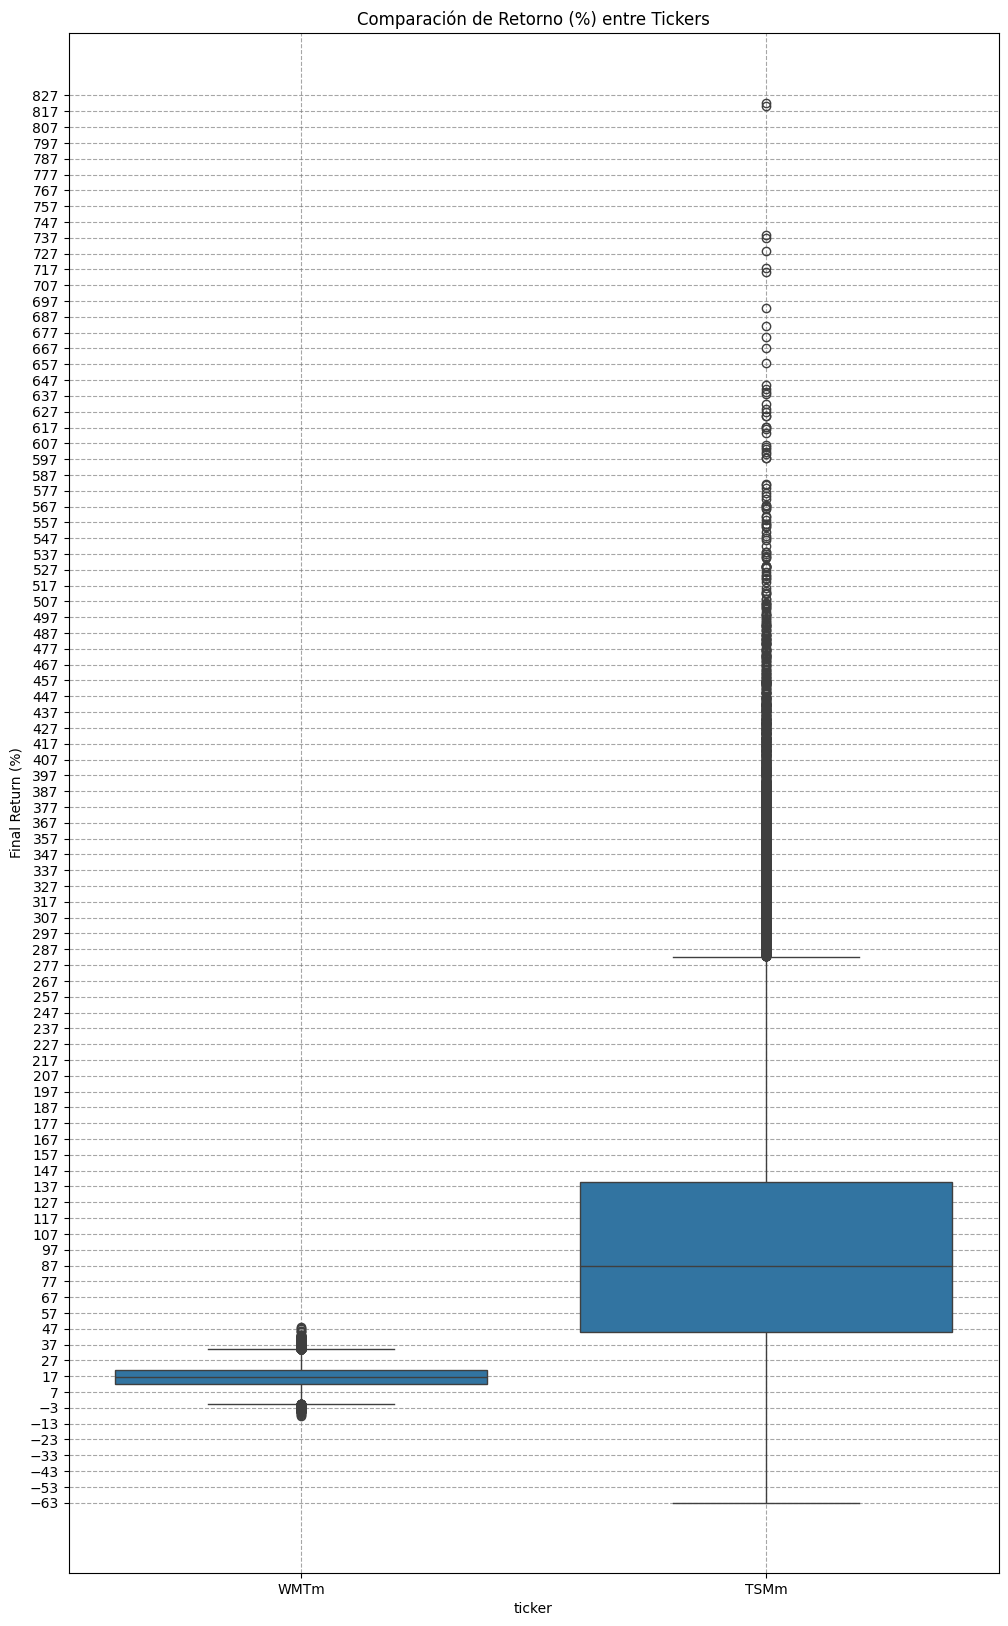

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generar el gráfico
plt.figure(figsize=(12, 20))
sns.boxplot(data=all_returns, x="ticker", y="Final Return (%)")
plt.title("Comparación de Retorno (%) entre Tickers")

# Configurar ticks mayores con más números
y_max = all_returns["Final Return (%)"].max()  # Valor máximo en el eje Y
y_min = all_returns["Final Return (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 10  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()
